In [62]:
import shutil
import os
import zipfile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

In [63]:
images = []
nation = []
genders = []

# Dataset is from the following paper: https://arxiv.org/pdf/1702.08423
for i in os.listdir(os.path.expanduser("~/Person-feature-detection/Datasets/utkface-dataset/UTKFace/"))[0:10000]:
    if i.count('_') >= 3:
        split = i.split('_')
        genders.append(int(split[1]))
        nation.append(int(split[2]))
        images.append(Image.open(os.path.expanduser("~/Person-feature-detection/Datasets/utkface-dataset/UTKFace/" + i)))

In [64]:
images = pd.Series(list(images), name = 'Images')
nation = pd.Series(list(nation), name = 'Nation')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, nation, genders], axis=1)
print(df)

                                                 Images  Nation  Genders
0     <PIL.JpegImagePlugin.JpegImageFile image mode=...       2        1
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...       3        0
2     <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        1
3     <PIL.JpegImagePlugin.JpegImageFile image mode=...       2        1
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...       3        0
...                                                 ...     ...      ...
9994  <PIL.JpegImagePlugin.JpegImageFile image mode=...       2        1
9995  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        1
9996  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        1
9997  <PIL.JpegImagePlugin.JpegImageFile image mode=...       1        0
9998  <PIL.JpegImagePlugin.JpegImageFile image mode=...       1        1

[9999 rows x 3 columns]


In [65]:
df['Nation'].unique()

array([2, 3, 0, 1, 4])

In [66]:
nation_labels = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Others"
}

df['NationLabel'] = df['Nation'].map(nation_labels)

print(df.head(20))


# print(df["NationLabel"].value_counts())

                                               Images  Nation  Genders  \
0   <PIL.JpegImagePlugin.JpegImageFile image mode=...       2        1   
1   <PIL.JpegImagePlugin.JpegImageFile image mode=...       3        0   
2   <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        1   
3   <PIL.JpegImagePlugin.JpegImageFile image mode=...       2        1   
4   <PIL.JpegImagePlugin.JpegImageFile image mode=...       3        0   
5   <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        0   
6   <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        0   
7   <PIL.JpegImagePlugin.JpegImageFile image mode=...       1        1   
8   <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        0   
9   <PIL.JpegImagePlugin.JpegImageFile image mode=...       3        0   
10  <PIL.JpegImagePlugin.JpegImageFile image mode=...       4        0   
11  <PIL.JpegImagePlugin.JpegImageFile image mode=...       1        0   
12  <PIL.JpegImagePlugin.JpegImageFile

/tmp/ipykernel_25614/3268449424.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('NationLabel').apply(lambda x: x.sample(min(len(x), 1600), random_state=42))


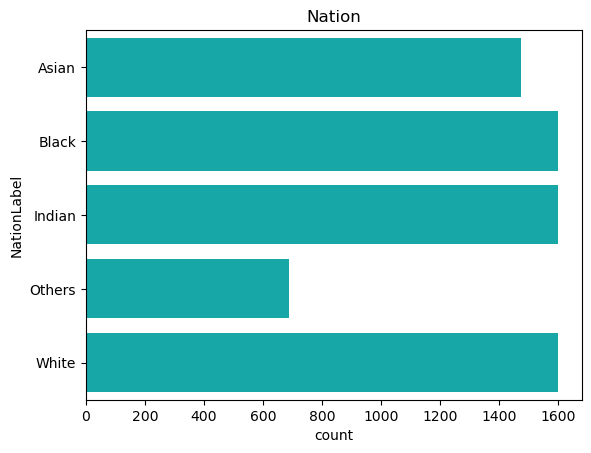

                                                 Images  Nation  Genders  \
4260  <PIL.JpegImagePlugin.JpegImageFile image mode=...       3        0   
3748  <PIL.JpegImagePlugin.JpegImageFile image mode=...       3        0   
385   <PIL.JpegImagePlugin.JpegImageFile image mode=...       2        0   
6461  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        0   
3648  <PIL.JpegImagePlugin.JpegImageFile image mode=...       3        0   
4948  <PIL.JpegImagePlugin.JpegImageFile image mode=...       4        1   
2897  <PIL.JpegImagePlugin.JpegImageFile image mode=...       1        1   
6502  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        0   
6263  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        0   
6922  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0        1   
2507  <PIL.JpegImagePlugin.JpegImageFile image mode=...       1        0   
4062  <PIL.JpegImagePlugin.JpegImageFile image mode=...       3        0   
306   <PIL.J

In [67]:
df_sampled = df.groupby('NationLabel').apply(lambda x: x.sample(min(len(x), 1600), random_state=42))
df_sampled = df_sampled.reset_index(drop=True)

df_sampled['ImageFilename'] = df_sampled['Images'].apply(lambda img: os.path.basename(img.filename))

plt.title('Nation')
sns.countplot(y=df_sampled['NationLabel'], color="c")
plt.show()

print(df_sampled.sample(20))

In [68]:
source_folder = os.path.expanduser("~/Person-feature-detection/Datasets/utkface-dataset/UTKFace")
white_nation_folder = os.path.expanduser("~/Person-feature-detection/nation/White/")
other_nation_folder = os.path.expanduser("~/Person-feature-detection/nation/Other/")
indian_nation_folder = os.path.expanduser("~/Person-feature-detection/nation/Indian/")
black_nation_folder = os.path.expanduser("~/Person-feature-detection/nation/Black/")
asian_nation_folder = os.path.expanduser("~/Person-feature-detection/nation/Asian/")

os.makedirs(white_nation_folder, exist_ok=True)
os.makedirs(other_nation_folder, exist_ok=True)
os.makedirs(indian_nation_folder, exist_ok=True)
os.makedirs(black_nation_folder, exist_ok=True)
os.makedirs(asian_nation_folder, exist_ok=True)

for _, row in df_sampled.iterrows():
    image_name = row['ImageFilename']
    nation = row['NationLabel']
    
    source_path = os.path.join(source_folder, image_name)
    
    if nation == "White":
        target_path = os.path.join(white_nation_folder, image_name)
    elif nation == "Others":
        target_path = os.path.join(other_nation_folder, image_name)
    elif nation == "Indian":
        target_path = os.path.join(indian_nation_folder, image_name)
    elif nation == "Black":
        target_path = os.path.join(black_nation_folder, image_name)
    elif nation == "Asian":
        target_path = os.path.join(asian_nation_folder, image_name)
    
    if os.path.exists(source_path):
        shutil.copy(source_path, target_path)
    else:
        print(f"File not found: {source_path}")

In [69]:
train_folder = os.path.expanduser("~/Person-feature-detection/nation/Train/")
val_folder = os.path.expanduser("~/Person-feature-detection/nation/Validate/")
test_folder = os.path.expanduser("~/Person-feature-detection/nation/Test/")

os.makedirs(os.path.join(train_folder, "White"), exist_ok=True)
os.makedirs(os.path.join(train_folder, "Other"), exist_ok=True)
os.makedirs(os.path.join(train_folder, "Indian"), exist_ok=True)
os.makedirs(os.path.join(train_folder, "Black"), exist_ok=True)
os.makedirs(os.path.join(train_folder, "Asian"), exist_ok=True)

os.makedirs(os.path.join(val_folder, "White"), exist_ok=True)
os.makedirs(os.path.join(val_folder, "Other"), exist_ok=True)
os.makedirs(os.path.join(val_folder, "Indian"), exist_ok=True)
os.makedirs(os.path.join(val_folder, "Black"), exist_ok=True)
os.makedirs(os.path.join(val_folder, "Asian"), exist_ok=True)

os.makedirs(os.path.join(test_folder, "White"), exist_ok=True)
os.makedirs(os.path.join(test_folder, "Other"), exist_ok=True)
os.makedirs(os.path.join(test_folder, "Indian"), exist_ok=True)
os.makedirs(os.path.join(test_folder, "Black"), exist_ok=True)
os.makedirs(os.path.join(test_folder, "Asian"), exist_ok=True)

def move_images(images, source_folder, target_folder):
    for image in images:
        source_path = os.path.join(source_folder, image)
        
        if os.path.isfile(source_path):
            target_path = os.path.join(target_folder, image)
            shutil.copy(source_path, target_path)
        else:
            print(f"Skipped: {source_path} (It's a dir not a file)")

white_nation_images = os.listdir(white_nation_folder)
other_nation_images = os.listdir(other_nation_folder)
indian_nation_images = os.listdir(indian_nation_folder)
black_nation_images = os.listdir(black_nation_folder)
asian_nation_images = os.listdir(asian_nation_folder)

white_train, white_temp = train_test_split(white_nation_images, test_size=0.2, random_state=42)
white_val, white_test = train_test_split(white_temp, test_size=0.5, random_state=42)

other_train, other_temp = train_test_split(other_nation_images, test_size=0.2, random_state=42)
other_val, other_test = train_test_split(other_temp, test_size=0.5, random_state=42)

indian_train, indian_temp = train_test_split(indian_nation_images, test_size=0.2, random_state=42)
indian_val, indian_test = train_test_split(indian_temp, test_size=0.5, random_state=42)

black_train, black_temp = train_test_split(black_nation_images, test_size=0.2, random_state=42)
black_val, black_test = train_test_split(black_temp, test_size=0.5, random_state=42)

asian_train, asian_temp = train_test_split(asian_nation_images, test_size=0.2, random_state=42)
asian_val, asian_test = train_test_split(asian_temp, test_size=0.5, random_state=42)


# Move the images
move_images(white_train, white_nation_folder, os.path.join(train_folder, "White"))
move_images(white_val, white_nation_folder, os.path.join(val_folder, "White"))
move_images(white_test, white_nation_folder, os.path.join(test_folder, "White"))

move_images(other_train, other_nation_folder, os.path.join(train_folder, "Other"))
move_images(other_val, other_nation_folder, os.path.join(val_folder, "Other"))
move_images(other_test, other_nation_folder, os.path.join(test_folder, "Other"))

move_images(indian_train, indian_nation_folder, os.path.join(train_folder, "Indian"))
move_images(indian_val, indian_nation_folder, os.path.join(val_folder, "Indian"))
move_images(indian_test, indian_nation_folder, os.path.join(test_folder, "Indian"))

move_images(black_train, black_nation_folder, os.path.join(train_folder, "Black"))
move_images(black_val, black_nation_folder, os.path.join(val_folder, "Black"))
move_images(black_test, black_nation_folder, os.path.join(test_folder, "Black"))

move_images(asian_train, asian_nation_folder, os.path.join(train_folder, "Asian"))
move_images(asian_val, asian_nation_folder, os.path.join(val_folder, "Asian"))
move_images(asian_test, asian_nation_folder, os.path.join(test_folder, "Asian"))